<a href="https://colab.research.google.com/github/bruaba/mask_detection/blob/main/facemaskrecognitionv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Elio Khater

In [19]:
from google.colab import drive
drive.mount('/content/drive/')

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MaskTrainDataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/MaskTrainDataset/images/8483039f2227e7ef.jpg
/content/drive/MyDrive/MaskTrainDataset/images/00040081c1c7efef.jpg
/content/drive/MyDrive/MaskTrainDataset/images/0303277f1370175f.jpg
/content/drive/MyDrive/MaskTrainDataset/images/808000000203ffff.jpg
/content/drive/MyDrive/MaskTrainDataset/images/1f5fdb8f8f878302.jpg
/content/drive/MyDrive/MaskTrainDataset/images/003bffff9fbf1000.jpg
/content/drive/MyDrive/MaskTrainDataset/images/00e1e8f83c3d1c07.jpg
/content/drive/MyDrive/MaskTrainDataset/images/9f3f1bf991315111.jpg
/content/drive/MyDrive/MaskTrainDataset/images/1f1b18183e1c0c20.jpg
/content/drive/MyDrive/MaskTrainDataset/images/5f5f1f1e1c100000.jpg
/content/drive/MyDrive/MaskTrainDataset/images/80c1fffebcdc1601.jpg
/content/drive/MyDrive/MaskTrainDataset/images/5f9d1c181c1c1e5e.jpg
/content/drive/MyDrive/MaskTrainDataset/images/30fefe24f6363c7c.jpg
/content/drive/MyDrive/MaskTrainDataset/images/bfbf6341207c4bc2.j

In [20]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MaskTrainDataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/MaskTrainDataset/images/8483039f2227e7ef.jpg
/content/drive/MyDrive/MaskTrainDataset/images/00040081c1c7efef.jpg
/content/drive/MyDrive/MaskTrainDataset/images/0303277f1370175f.jpg
/content/drive/MyDrive/MaskTrainDataset/images/808000000203ffff.jpg
/content/drive/MyDrive/MaskTrainDataset/images/1f5fdb8f8f878302.jpg
/content/drive/MyDrive/MaskTrainDataset/images/003bffff9fbf1000.jpg
/content/drive/MyDrive/MaskTrainDataset/images/00e1e8f83c3d1c07.jpg
/content/drive/MyDrive/MaskTrainDataset/images/9f3f1bf991315111.jpg
/content/drive/MyDrive/MaskTrainDataset/images/1f1b18183e1c0c20.jpg
/content/drive/MyDrive/MaskTrainDataset/images/5f5f1f1e1c100000.jpg
/content/drive/MyDrive/MaskTrainDataset/images/80c1fffebcdc1601.jpg
/content/drive/MyDrive/MaskTrainDataset/images/5f9d1c181c1c1e5e.jpg
/content/drive/MyDrive/MaskTrainDataset/images/30fefe24f6363c7c.jpg
/content/drive/MyDrive/MaskTrainDataset/images/bfbf6341207c4bc2.j

In [21]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand

def generate_box(obj):  
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)



In [22]:
imgs = list(sorted(os.listdir("/content/drive/MyDrive/MaskTrainDataset/images")))
len(imgs)

2655

In [23]:
labels = list(sorted(os.listdir("/content/drive/MyDrive/MaskTrainDataset/annotations")))
len(labels)

2655

In [44]:
i=0
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
filenamess=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MaskTrainDataset/annotations/'):
    for filename in filenames:
        filenamess.append(filename.split(".")[0]);
        target, numobj = generate_target(i, os.path.join(dirname, filename))
        targets.append(target)
        numobjs.append(numobj)
        i=i+1

len(filenamess)

2655

In [45]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(2654):
    img_path = "/content/drive/MyDrive/MaskTrainDataset/images/"+filenamess[i]+".jpg"
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        if img is not None:
          img1=img[locs[1]:locs[3],locs[0]:locs[2]]
          img1 = cv2.resize(img1, (224, 224))
          img1 = img_to_array(img1)
          img1 = preprocess_input(img1)
          face_images.append(img1)
          face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [26]:
len(face_labels)

3383

In [27]:
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

{0: 788, 1: 2359, 2: 236}

In [28]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [29]:
#Perform data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [30]:
#define the model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [31]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [32]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [33]:
del targets,face_images,face_labels

In [34]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

Epoch 1/20
84/84 [==============================] - 139s 2s/step - loss: 2.5945 - accuracy: 0.4861 - val_loss: 0.8855 - val_accuracy: 0.6100
Epoch 2/20
84/84 [==============================] - 136s 2s/step - loss: 1.8423 - accuracy: 0.6752 - val_loss: 0.8148 - val_accuracy: 0.6248
Epoch 3/20
84/84 [==============================] - 138s 2s/step - loss: 1.6156 - accuracy: 0.6793 - val_loss: 0.6222 - val_accuracy: 0.7223
Epoch 4/20
84/84 [==============================] - 136s 2s/step - loss: 1.3849 - accuracy: 0.7495 - val_loss: 0.4898 - val_accuracy: 0.8213
Epoch 5/20
84/84 [==============================] - 135s 2s/step - loss: 1.4133 - accuracy: 0.7609 - val_loss: 0.5434 - val_accuracy: 0.7784
Epoch 6/20
84/84 [==============================] - 135s 2s/step - loss: 1.3147 - accuracy: 0.7635 - val_loss: 0.5807 - val_accuracy: 0.7622
Epoch 7/20
84/84 [==============================] - 134s 2s/step - loss: 1.1499 - accuracy: 0.7801 - val_loss: 0.5177 - val_accuracy: 0.7873
Epoch 8/20
84

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.66      0.94      0.78       158
           1       0.97      0.78      0.87       472
           2       0.39      0.57      0.47        47

    accuracy                           0.81       677
   macro avg       0.67      0.77      0.70       677
weighted avg       0.86      0.81      0.82       677



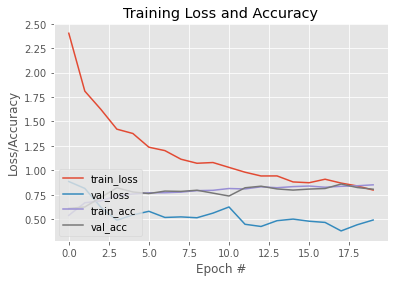

In [35]:



print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [36]:
model.save('kaggle1.h5')

In [37]:
import keras
model = keras.models.load_model('kaggle1.h5')

In [40]:
model.save('kaggle2.h5')

In [38]:
#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
84/84 [==============================] - 141s 2s/step - loss: 0.8070 - accuracy: 0.8644 - val_loss: 0.4866 - val_accuracy: 0.8065
Epoch 2/20
84/84 [==============================] - 137s 2s/step - loss: 0.7490 - accuracy: 0.8328 - val_loss: 0.4323 - val_accuracy: 0.8257
Epoch 3/20
84/84 [==============================] - 137s 2s/step - loss: 0.7375 - accuracy: 0.8539 - val_loss: 0.4875 - val_accuracy: 0.8124
Epoch 4/20
84/84 [==============================] - 137s 2s/step - loss: 0.8237 - accuracy: 0.8504 - val_loss: 0.5159 - val_accuracy: 0.7976
Epoch 5/20
84/84 [==============================] - 138s 2s/step - loss: 0.7360 - accuracy: 0.8505 - val_loss: 0.3770 - val_accuracy: 0.8597
Epoch 6/20
84/84 [==============================] - 137s 2s/step - loss: 0.7363 - accuracy: 0.8504 - val_loss: 0.4850 - val_accuracy: 0.8050
Epoch 7/20
84/84 [==============================] - 137s 2s/step - loss: 0.7432 - accuracy: 0.8522 - val

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       158
           1       0.95      0.90      0.92       472
           2       0.49      0.62      0.55        47

    accuracy                           0.88       677
   macro avg       0.75      0.80      0.77       677
weighted avg       0.89      0.88      0.88       677



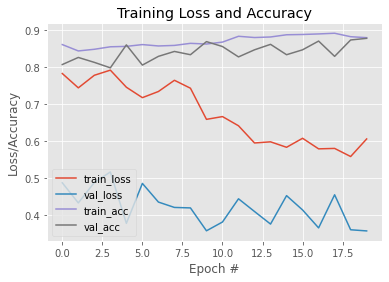

In [39]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()